We analyse the problems that teh GBT can have when trying to classify the problem of:
$$
\begin{align}
E-p<0.5 \Rightarrow \text{Class } 0,\\
E-p\geq 0.5 \Rightarrow \text{Class } 1. 
\end{align}
$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbs

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,log_loss

np.random.seed(2210)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
font_size = 24

In [2]:
nfolds = 5
folds = StratifiedKFold(n_splits=nfolds,random_state=1,shuffle=True)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': .3,
    'num_threads': 4,
    'is_unbalance':'true'
}

The case 1 is when we add some quantity between 0 and 100 while the second test is when we add a quantity between 0 and 1.

In [3]:
N = 50000
p_train = np.random.rand(N)*1000
p_valid = np.random.rand(N)*1000
E_train = p_train+np.random.rand(N)*100
E_valid = p_valid +np.random.rand(N)*100
E_train2 = p_train+np.random.rand(N)
E_valid2 = p_valid +np.random.rand(N)

In [4]:
x_train = np.column_stack((E_train,p_train))
x_valid = np.column_stack((E_valid,p_valid))
x_train2 = np.column_stack((E_train2,p_train))
x_valid2 = np.column_stack((E_valid2,p_valid))

y_train = np.zeros(N)
y_train[(E_train-p_train)>=50]=1 
y_valid = np.zeros(N)
y_valid[(E_valid-p_valid)>=50]=1 
y_train2 = np.zeros(N)
y_train2[(E_train2-p_train)>=0.5]=1 
y_valid2 = np.zeros(N)
y_valid2[(E_valid2-p_valid)>=0.5]=1

In [5]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': .3,
    'num_threads': 4
}

In [6]:
predict = np.empty(N)
models = []
for train_index,test_index in folds.split(x_train,y_train):
    X_tr = x_train[train_index]
    X_ts = x_train[test_index]
    y_tr = y_train[train_index]
    y_ts = y_train[test_index]
    dtrain = lgb.Dataset(X_tr,y_tr)
    dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
    gbm = lgb.train(params, dtrain, 
                num_boost_round=5000,
                valid_sets=dtest,
                early_stopping_rounds=10,
                verbose_eval=50)
    models.append(gbm)
    predict[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)

Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's binary_logloss: 0.1998
[100]	valid_0's binary_logloss: 0.109093
[150]	valid_0's binary_logloss: 0.0789999
[200]	valid_0's binary_logloss: 0.0624167
[250]	valid_0's binary_logloss: 0.0539837
[300]	valid_0's binary_logloss: 0.0496179
[350]	valid_0's binary_logloss: 0.0462935
[400]	valid_0's binary_logloss: 0.0446333
[450]	valid_0's binary_logloss: 0.0428644
[500]	valid_0's binary_logloss: 0.0417401
[550]	valid_0's binary_logloss: 0.0409311
[600]	valid_0's binary_logloss: 0.0400861
[650]	valid_0's binary_logloss: 0.0394683
Early stopping, best iteration is:
[684]	valid_0's binary_logloss: 0.03911
Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's binary_logloss: 0.199207
[100]	valid_0's binary_logloss: 0.110672
[150]	valid_0's binary_logloss: 0.0783347
[200]	valid_0's binary_logloss: 0.0618264
[250]	valid_0's binary_logloss: 0.0535697
[300]	valid_0's binary_logloss: 0.0484799
[350]	valid_0's binary_logl

In [7]:
print("Roc score training:", roc_auc_score(y_train,predict))

Roc score training: 0.999222196429


In [8]:
def kfold_predict(models,X):
    validation_predictions = np.empty((len(models),X.shape[0]))
    for i,model in enumerate(models):
        validation_predictions[i] = model.predict(X)
    return validation_predictions.mean(axis=0)

In [9]:
predict_valid = kfold_predict(models,x_valid)

In [10]:
print("Roc score validation:", roc_auc_score(y_valid,predict_valid))

Roc score validation: 0.999694604967


In [11]:
predict2 = np.empty(N)
models2 = []
for train_index,test_index in folds.split(x_train2,y_train2):
    X_tr = x_train2[train_index]
    X_ts = x_train2[test_index]
    y_tr = y_train2[train_index]
    y_ts = y_train2[test_index]
    dtrain = lgb.Dataset(X_tr,y_tr)
    dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
    gbm = lgb.train(params, dtrain, 
                num_boost_round=5000,
                valid_sets=dtest,
                early_stopping_rounds=10,
                verbose_eval=50)
    models2.append(gbm)
    predict2[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)

Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.692168
Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's binary_logloss: 0.692169
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.691733
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.69259
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.692725
Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's binary_logloss: 0.692577
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.692477


In [12]:
print("Roc score training:", roc_auc_score(y_train2,predict2))

Roc score training: 0.51843775281


In [13]:
predict_valid2 = kfold_predict(models2,x_valid2)

In [14]:
print("Roc score validation:", roc_auc_score(y_valid2,predict_valid2))

Roc score validation: 0.521268831212


To understand why this happens, we plot two cases,one where we add a value between 0 and 1 and one where we add a value between 0 and 6. We start with the first case.

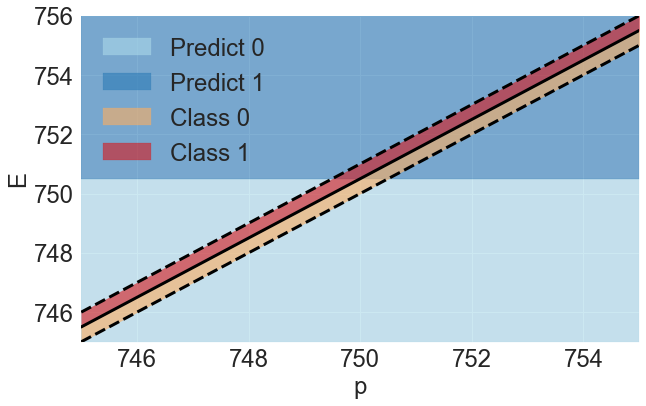

In [15]:
plt.plot([745,755],[745.5,755.5],color='black',lw=3)
plt.plot([745,755],[745,755],color='black',lw=3,linestyle='dashed')
plt.plot([745,755],[746,756],color='black',lw=3,linestyle='dashed')
plt.xlim(745,755)
plt.fill_between([745,755],[745,745],[750.5,750.5],alpha=0.6,
                 color='#abd9e9',label='Predict 0')
plt.fill_between([745,755],[750.5,750.5],[756,756],alpha=0.6,
                 color='#2c7bb6',label='Predict 1')
plt.fill_between([745,755],[745,755],[745.5,755.5],alpha=0.6,
                 color='#fdae61',label='Class 0')
plt.fill_between([745,755],[745.5,755.5],[746,756],alpha=0.6,
                 color='#d7191c',label='Class 1')
plt.ylim(745,756)
plt.legend(fontsize = font_size)
plt.tick_params(labelsize=font_size)
plt.xlabel('p',fontsize=font_size)
plt.ylabel('E',fontsize=font_size)
plt.savefig('GBTProb1.pdf')

We compute the fraction of correct area predicted.

In [16]:
def trapArea(a,b,c,d):
    return 0.5*(a+b)*(c**2-0.25*(b-a+(c*c-d*d)/(b-a))**2)**(0.5)

In [17]:
A1 = trapArea((2*4.5**2)**0.5,50**0.5,0.5,0.5)  #Smaller trapezoid
A2 = trapArea(50**0.5,(2*5.5**2)**0.5,0.5,0.5) #Bigger trapezoid
A2/(A1+A2)

0.5250000000000004

The same when adding a value between 0 and 6.

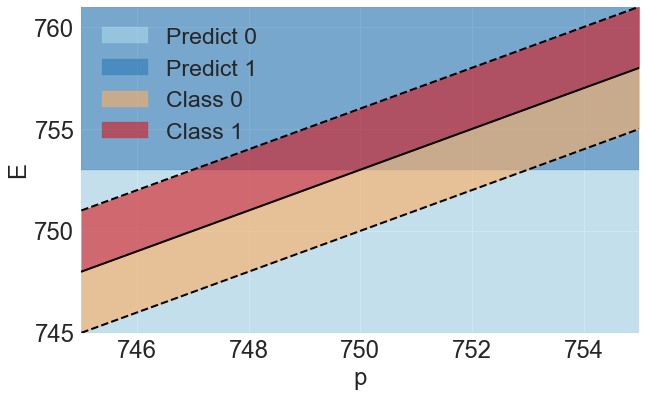

In [18]:
plt.plot([745,755],[748,758],color='black',lw=2)
plt.plot([745,755],[745,755],color='black',lw=2,linestyle='dashed')
plt.plot([745,755],[751,761],color='black',lw=2,linestyle='dashed')
plt.xlim(745,755)
plt.fill_between([745,755],[745,745],[753,753],alpha=0.6,
                 color='#abd9e9',label='Predict 0')
plt.fill_between([745,755],[753,753],[761,761],alpha=0.6,
                 color='#2c7bb6',label='Predict 1')
plt.fill_between([745,755],[745,755],[748,758],alpha=0.6,
                 color='#fdae61',label='Class 0')
plt.fill_between([745,755],[748,758],[751,761],alpha=0.6,
                 color='#d7191c',label='Class 1')
plt.ylim(745,761)
plt.legend(fontsize = font_size-1)
plt.tick_params(labelsize=font_size)
plt.xlabel('p',fontsize=font_size)
plt.ylabel('E',fontsize=font_size)
plt.savefig('GBTProb2.pdf')

In [19]:
A1 = trapArea(8**0.5,50**0.5,3,3)  #Smaller trapezoid
A2 = trapArea(50**0.5,128**0.5,3,3) #Bigger trapezoid
A2/(A1+A2)

0.65